# INITIAL TRAINING RESULTS ANALYSIS - WITH OVERSAMPLING

In this notebook we will look in some depth into the initial results obtained on the S4 sample training subset (75% of the samples, but with oversampling applied with SMOTE algorithm).

Notice that in this case we cannot exactly do the same as with the validation sample, as in this case we don't have the information of the stars, because the sample is oversampled, so we cannot see graphics of `predict_proba` vs variables as amplitude, frequency, etc.

Maybe we could do that only with the original stars in the training sample.

## Modules and configuration

### Modules

In [1]:
import pandas as pd

from astropy.table import QTable
from astropy import units

from sklearn.metrics import precision_score, confusion_matrix

import pickle

import matplotlib.pyplot as plt

from matplotlib.lines import Line2D

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
RESULTS_SUMMARY_FILE = "ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv"
PREDICTIONS_FILE = "ModelPreselection_TrainPredictions_OversampledSMOTE_n3.csv"

S4_METADATA_FILE = "../data/DATASETS_CESIUM/cesium_ML_FINAL_S4.csv"
S4_RV_CURVES_INFO_FILE = "../data/SYNTH_RV_SAMPLES/RV_FINAL_ML_SyntheticDatasets.csv"

REL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle"
UNREL_FEATURES_IN = "../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle"

MODELS_FOLDER = "../data/ML_MODELS/ML_model_preselection/"

ADD_META_COLUMNS = [
    'S3_sampling_idx', 'S3_Tobs', 'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints',
    'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', 'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale',
    'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev'
]

IMG_FOLDER = "./img/"

### Functions

In [3]:
def compare_dist(data, x_col, hue_col=None, varname=None, fig_title=None, fig_filename=None,
                 stat='count', kde=False, hist_fill=True):
    '''Plots and saves overlapped histograms.
    Changed to use the new functions, instead of the deprecated "distplot"'''
    # Plots and saves the figure
    #kwargs = dict(kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill},
    #              kde_kws={'linewidth': 2})
    #kwargs = dict(hist_kws={'alpha': .30, 'histtype': 'step', 'linewidth': 2, 'fill': hist_fill})
    plt.figure(figsize=(10,5))
    ax = sns.histplot(data, x=x_col, hue=hue_col, stat=stat, common_norm=False,
                      kde=kde, fill=hist_fill, alpha=0.25)
    if varname is None:
        ax.set_xlabel(x_col, fontsize=12)
    else:
        ax.set_xlabel(varname, fontsize=12)
    ax.set_xlim(0.0, 1.0)
    if fig_title is None:
        ax.set_title("Comparison of distributions", fontsize=16)
    else:
        ax.set_title(fig_title, fontsize=16)
    ax.set_ylabel('Frequency of occurrence', fontsize=12)
    #ax.legend(loc='best');
    # Save the image:
    if fig_filename is None:
        pass
    else:
        ax.get_figure().savefig(fig_filename, format='jpg');


## Load data

### Load reliable features

In [4]:
REL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Reliable_features.pickle'

In [5]:
rel_features = pickle.load(open(REL_FEATURES_IN, 'rb'))
print(rel_features)

['all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_rel_phase3', '

In [6]:
UNREL_FEATURES_IN

'../data/ML_MODELS/ML_pipeline_steps/Unreliable_features.pickle'

In [7]:
unrel_features = pickle.load(open(UNREL_FEATURES_IN, 'rb'))
print(unrel_features)

['avg_err', 'avgt', 'mean', 'med_err', 'std_err', 'amplitude', 'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80', 'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum', 'percent_amplitude', 'percent_close_to_median', 'percent_difference_flux_percentile', 'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std', 'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile', 'freq1_amplitude1', 'freq1_amplitude2', 'freq1_amplitude3', 'freq1_amplitude4', 'freq1_freq', 'freq1_lambda', 'freq1_signif', 'freq2_amplitude1', 'freq2_amplitude2', 'freq2_amplitude3', 'freq2_amplitude4', 'freq2_freq', 'freq3_amplitude1', 'freq3_amplitude2', 'freq3_amplitude3', 'freq3_amplitude4', 'freq3_freq', 'freq_amplitude_ratio_21', 'freq_amplitude_ratio_31', 'freq_frequency_ratio_21', 'freq_frequency_ratio_31', 'freq_model_max

### Load S4 training / validation results

In [8]:
MODELS_FOLDER + RESULTS_SUMMARY_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv'

In [9]:
val_results = pd.read_csv(MODELS_FOLDER + RESULTS_SUMMARY_FILE, sep=',', decimal='.')
val_results

,Classifier,BM_tr_precision,BM_val_precision,BMOPT_tr_precision,BMOPT_val_precision
0,Perceptron,0.631130,0.102564,0.620387,0.093023
1,LogisticRegression,0.662739,0.087379,0.665685,0.076923
2,PassiveAggressiveClassifier,0.650826,0.102273,0.624526,0.104000
3,SVC,0.934473,0.139535,0.972344,0.193548
4,KNeighborsClassifier,0.765376,0.113208,1.000000,0.117647
5,GaussianProcessClassifier,1.000000,0.108108,0.976436,0.133333
6,DecisionTreeClassifier,1.000000,0.075758,0.950525,0.120690
7,RandomForestClassifier,1.000000,0.200000,0.989410,0.055556
8,AdaBoostClassifier,0.870370,0.132075,0.919355,0.140000
9,GradientBoostingClassifier,0.969298,0.095238,0.841954,0.086957


### Load S4 training predictions

In [10]:
MODELS_FOLDER + PREDICTIONS_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_TrainPredictions_OversampledSMOTE_n3.csv'

In [11]:
tr_pred = pd.read_csv(MODELS_FOLDER + PREDICTIONS_FILE, sep=',', decimal='.')
tr_pred

,Pulsating,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,...,PredictionProb_Perceptron,PredictionProb_LogisticRegression,PredictionProb_PassiveAggressiveClassifier,PredictionProb_SVC,PredictionProb_KNeighborsClassifier,PredictionProb_GaussianProcessClassifier,PredictionProb_DecisionTreeClassifier,PredictionProb_RandomForestClassifier,PredictionProb_AdaBoostClassifier,PredictionProb_GradientBoostingClassifier
0,0,-0.674126,0.519174,0.466681,0.766297,1.786498,-0.304944,0.843252,0.189055,1.390901,...,NaN,0.667095,NaN,NaN,0.0,0.363527,0.071429,0.295779,0.501447,0.549685
1,1,-1.626729,1.911247,-0.740748,0.691384,0.168331,1.522002,1.166420,0.157675,0.019744,...,NaN,0.715795,NaN,NaN,1.0,0.676525,1.000000,0.614086,0.496762,0.458713
2,0,-0.039057,-1.012107,0.013895,-0.357397,1.168762,-0.232282,-0.443941,-0.136007,-0.412519,...,NaN,0.634074,NaN,NaN,0.0,0.537343,0.000000,0.183967,0.494150,0.302085
3,0,-0.039057,1.632833,-0.514355,0.166993,1.477630,-0.544204,-0.572606,-0.586661,-0.338658,...,NaN,0.347344,NaN,NaN,0.0,0.434809,0.066667,0.234851,0.499231,0.393730
4,0,0.596012,-0.176863,-1.042605,-0.432310,0.242158,-0.277263,-0.498198,-0.370020,-0.451106,...,NaN,0.568765,NaN,NaN,0.0,0.341284,0.000000,0.140025,0.489992,0.326507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,1,0.473173,-0.668664,0.135630,-0.259518,-1.373200,-0.470559,-0.589896,-0.548709,-0.448373,...,NaN,0.475518,NaN,NaN,1.0,0.752829,0.230769,0.801291,0.505634,0.594979
1340,1,-0.993662,-0.524004,0.918516,1.589867,-0.372796,-0.377095,-0.318659,-0.118490,-0.120285,...,NaN,0.777982,NaN,NaN,1.0,0.868844,1.000000,0.898676,0.512715,0.705304
1341,1,0.610021,-1.068148,0.492761,0.150468,-0.980256,-0.169826,-0.341273,-0.177918,-0.341825,...,NaN,0.434951,NaN,NaN,1.0,0.817803,0.943038,0.808745,0.505292,0.589810
1342,1,1.061356,-0.373715,0.099776,-0.660900,-1.102506,0.339215,-0.083127,0.190607,-0.361995,...,NaN,0.456802,NaN,NaN,1.0,0.765576,0.943038,0.841155,0.507061,0.643477


In [12]:
print(list(tr_pred.columns))

['Pulsating', 'all_times_nhist_numpeaks', 'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin', 'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4', 'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4', 'all_times_nhist_peak_3_to_4', 'all_times_nhist_peak_val', 'avg_double_to_single_step', 'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50', 'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000', 'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000', 'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000', 'cads_avg', 'cads_med', 'cads_std', 'med_double_to_single_step', 'n_epochs', 'std_double_to_single_step', 'total_time', 'percent_beyond_1_std', 'freq1_rel_phase2', 'freq1_rel_phase3', 'freq1_rel_phase4', 'freq2_rel_phase2', 'freq2_rel_phase3', 'freq2_rel_phase4', 'freq3_rel_phase2', 'freq3_r

#### Drop the features columns (in the training set we only had the 'reliable' features)

In [13]:
tr_pred.drop(
    columns=rel_features, inplace=True)
print(list(tr_pred.columns))

['Pulsating', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_Perceptron', 'PredictionProb_LogisticRegression', 'PredictionProb_PassiveAggressiveClassifier', 'PredictionProb_SVC', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier']


#### Drop the columns of prediction probabilities without values

In [14]:
tr_pred.drop(
    columns=['PredictionProb_Perceptron',
             'PredictionProb_PassiveAggressiveClassifier',
             'PredictionProb_SVC'], inplace=True)
print(list(tr_pred.columns))

['Pulsating', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier']


In [15]:
(tr_pred['Pulsating'] == 1).sum()

672

In [16]:
MODELS_FOLDER + RESULTS_SUMMARY_FILE

'../data/ML_MODELS/ML_model_preselection/ModelPreselection_PrecisionResults_OversampledSMOTE_n3.csv'

In [17]:
tr_results = pd.read_csv(MODELS_FOLDER + RESULTS_SUMMARY_FILE, sep=',', decimal='.')
tr_results

,Classifier,BM_tr_precision,BM_val_precision,BMOPT_tr_precision,BMOPT_val_precision
0,Perceptron,0.631130,0.102564,0.620387,0.093023
1,LogisticRegression,0.662739,0.087379,0.665685,0.076923
2,PassiveAggressiveClassifier,0.650826,0.102273,0.624526,0.104000
3,SVC,0.934473,0.139535,0.972344,0.193548
4,KNeighborsClassifier,0.765376,0.113208,1.000000,0.117647
5,GaussianProcessClassifier,1.000000,0.108108,0.976436,0.133333
6,DecisionTreeClassifier,1.000000,0.075758,0.950525,0.120690
7,RandomForestClassifier,1.000000,0.200000,0.989410,0.055556
8,AdaBoostClassifier,0.870370,0.132075,0.919355,0.140000
9,GradientBoostingClassifier,0.969298,0.095238,0.841954,0.086957


## Questions

We will address just the question of how the `predict_proba` distributions compare between the originally pulsating and non-pulsating stars.


In [18]:
clf_list = [clf.replace("PredictionProb_","") for clf in list(tr_pred.columns) if 'PredictionProb_' in clf]
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

In [19]:
print(list(tr_pred.columns))

['Pulsating', 'Prediction_Perceptron', 'Prediction_LogisticRegression', 'Prediction_PassiveAggressiveClassifier', 'Prediction_SVC', 'Prediction_KNeighborsClassifier', 'Prediction_GaussianProcessClassifier', 'Prediction_DecisionTreeClassifier', 'Prediction_RandomForestClassifier', 'Prediction_AdaBoostClassifier', 'Prediction_GradientBoostingClassifier', 'PredictionProb_LogisticRegression', 'PredictionProb_KNeighborsClassifier', 'PredictionProb_GaussianProcessClassifier', 'PredictionProb_DecisionTreeClassifier', 'PredictionProb_RandomForestClassifier', 'PredictionProb_AdaBoostClassifier', 'PredictionProb_GradientBoostingClassifier']


### Example

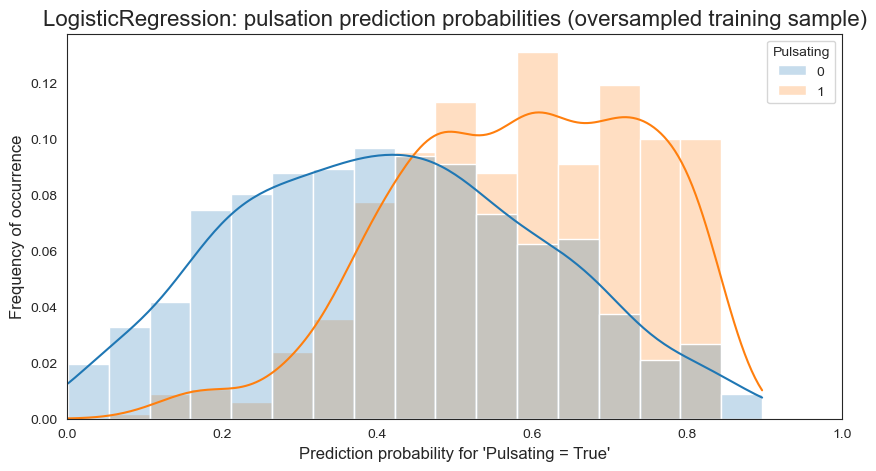

In [20]:
data = tr_pred.copy()
clf_name = clf_list[0]
x_col = 'PredictionProb_' + clf_name
hue_col = 'Pulsating'
varname = "Prediction probability for 'Pulsating = True'"
fig_title = clf_name + ": pulsation prediction probabilities (oversampled training sample)"
fig_filename = "ML_55_TEST_2.jpg"
stat = 'proportion'
kde = True
hist_fill=True

compare_dist(data, x_col, hue_col=hue_col,
             varname=varname, fig_title=fig_title,
             fig_filename=fig_filename,
             stat=stat, kde=kde, hist_fill=hist_fill)


### Distributions of `predict_proba`

In [21]:
clf_list

['LogisticRegression',
 'KNeighborsClassifier',
 'GaussianProcessClassifier',
 'DecisionTreeClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

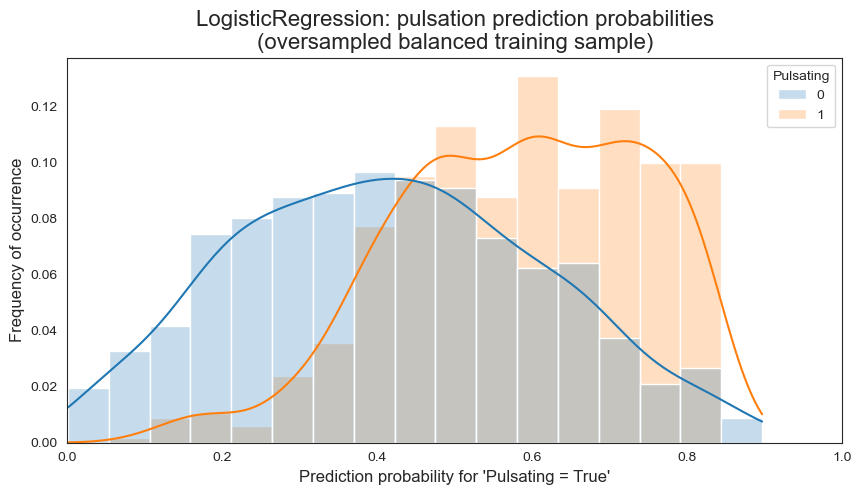

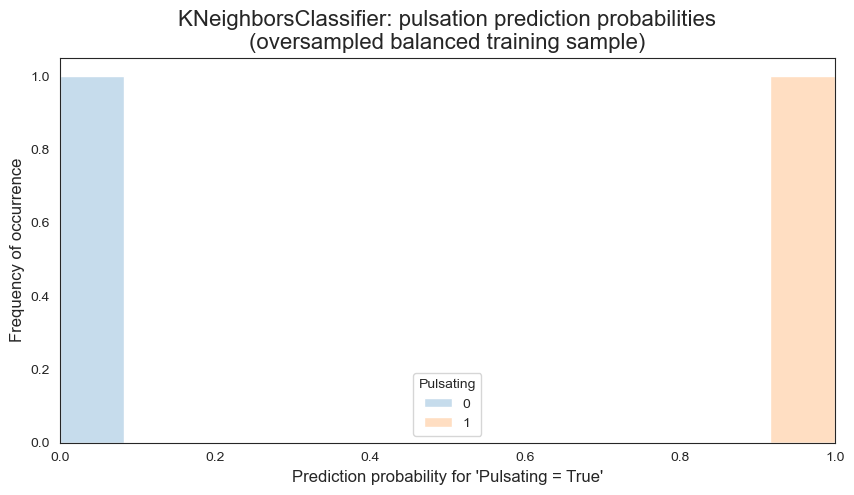

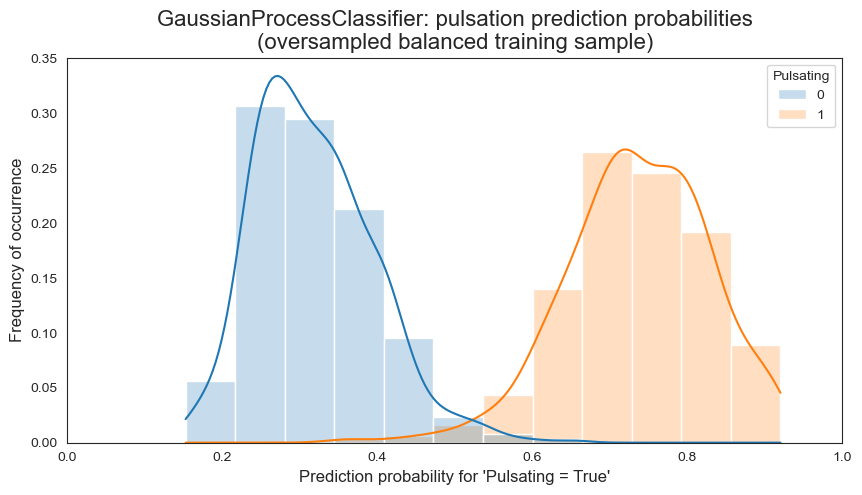

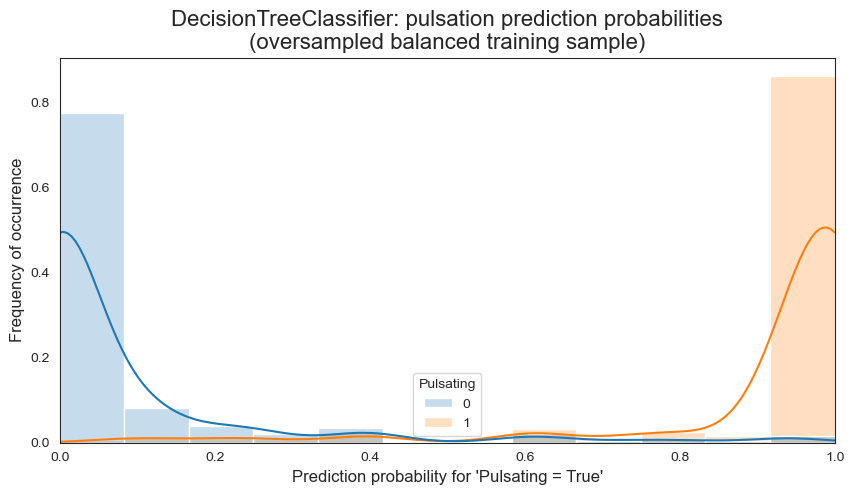

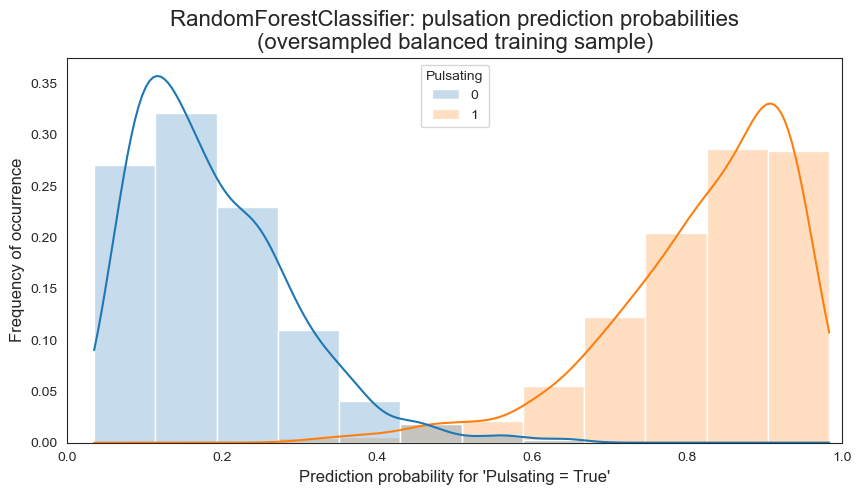

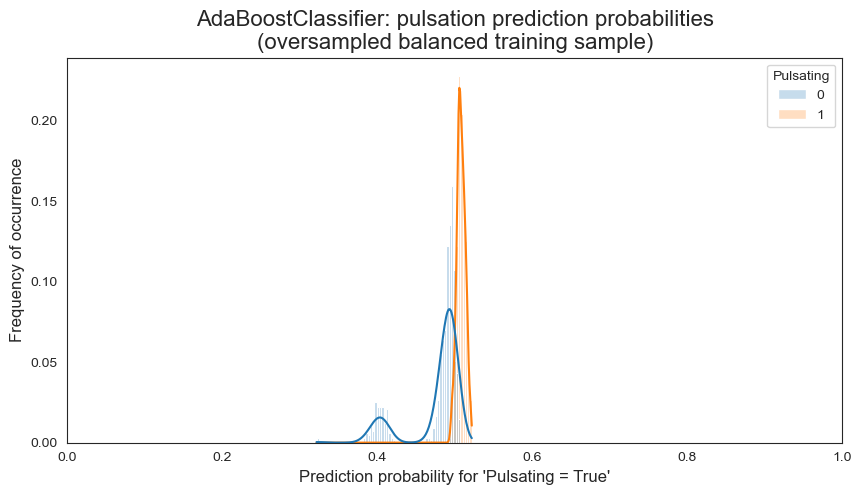

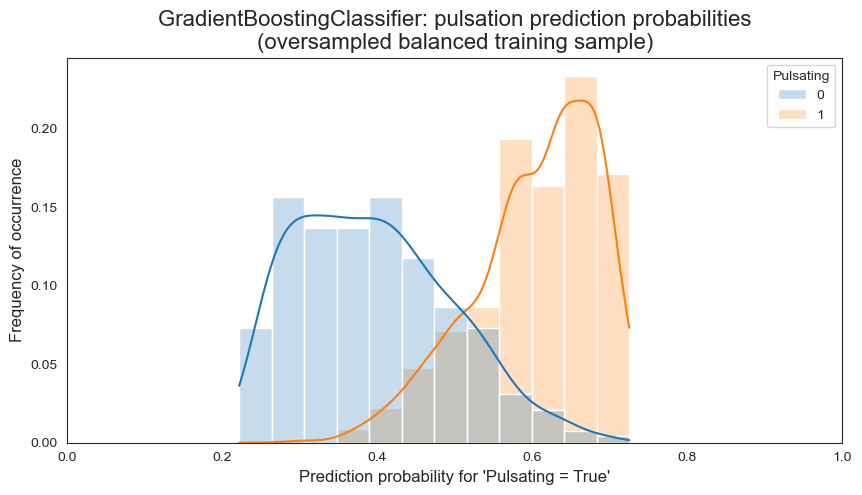

In [22]:
img_id = 0
for clf_name in clf_list:
    img_id += 1
    data = tr_pred.copy()
    x_col = 'PredictionProb_' + clf_name
    hue_col = 'Pulsating'
    varname = "Prediction probability for 'Pulsating = True'"
    fig_title = clf_name + ": pulsation prediction probabilities\n(oversampled balanced training sample)"
    fig_filename = IMG_FOLDER + "ML_56_01_" + str(img_id).zfill(2) +"_TrainingPredictionProb_" + clf_name + ".jpg"
    stat = 'proportion'
    kde = True
    hist_fill=True
    
    compare_dist(data, x_col, hue_col=hue_col,
                 varname=varname, fig_title=fig_title,
                 fig_filename=fig_filename,
                 stat=stat, kde=kde, hist_fill=hist_fill)


## Summary

**RESULTS:**

- The three classifiers which do a best job of discriminating the two classes of objects are (without taking into account, for the moment, the severe overfitting problem): `GaussianProcessClassifier`, `DecisionTreeClassifier` and `RandomForestClassifier`.
- The best one is, for sure `RandomForestClassifier`, followed by `DecisionTreeClassifier` and `GaussianProcessClassifier`.
- However, at the moment we would prefer to select these two classifiers:
  - `GaussianProcessClassifier`: because it was the one that performed best in the validation sample.
  - `DecisionTreeClassifier`: because of its ease of interpretability, which can help us to better understand and (future work) tune the apparently more powerful `RandomForestClassifier`. Additionally, decsiion tree classifiers offer several mechanisms to prevent overfitting.

**CONCLUSIONS:**

- In line with what we observed in the analysis if the initial validation results, we conmfirm the choice of these two classifiers for further work:
  - `GaussianProcessClassifier`: because it discriminates well both classes, and performed the best over the validation sample.
  - `DecisionTreeClassifier`: because is discriminates both classes reasonably well, offers several mechanisms to cure overfitting, and will help us understand the underlying rationale under the tree classification of our sample, with the view on improving the apparently more powerful `RandomForestClassifier`, bsased on the same concepts.